***COVID vs NonCOVID Image Classification using Feature Pyramid Networks***

This code provides an end-to-end solution for classifying medical images into two categories: 'COVID' and 'NonCOVID'. Utilizing the powerful capabilities of TensorFlow and Keras, the script implements a classification model based on the Feature Pyramid Network (FPN) architecture. Here's a summary of what the code entails:

**Environment Setup:**
Google Drive is mounted for data access.
Necessary libraries and tools, including a custom version of RetinaNet, are installed.

**Data Preparation:**
Images from the specified directory are loaded, resized, and normalized.
The data is then split into training and testing sets.

**Model Construction:**
A ResNet50V2 pre-trained model is loaded as the base model.
The Feature Pyramid Network (FPN) is constructed using features from different scales of the ResNet50V2 model.
For each feature level in the pyramid, classification heads are added to generate predictions.
The predictions from each pyramid level are concatenated and fed through a dense layer to get the final classification output.

**Model Training:**
The model is compiled using the RMSprop optimizer and binary cross-entropy loss.
Training is performed on the dataset, and the history of training is captured.

**Visualization:**
The training history is visualized, showing plots for training/validation accuracy and loss.

This script provides a comprehensive approach to classifying medical images using deep learning. It leverages a Feature Pyramid Network to generate multi-scale feature representations, enhancing the model's ability to detect patterns of varying scales in the images.

In [ ]:
#Connect your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install zipfile36
!pip install git+https://github.com/mr7495/RetinaNet

  Cloning https://github.com/mr7495/RetinaNet to /tmp/pip-req-build-dweg084d
  Running command git clone -q https://github.com/mr7495/RetinaNet /tmp/pip-req-build-dweg084d
  Running command git submodule update --init --recursive -q
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp37-cp37m-linux_x86_64.whl size=181956 sha256=c41105db7118ba963d12f3a31c9355825503d50e46bc497f1bb146bac85f2935
  Stored in directory: /tmp/pip-ephem-wheel-cache-qh8u_x_8/wheels/08/6d/f5/38473102b36a5975e02e8f339fbf85bc4d1b1c7c80dc68a595
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13345 sha256=33e36c6db06cc1e60037b5e13390acff2c16a4f56a570a35c9ec2ec995a747d4
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [ ]:
import keras
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv
import zipfile
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
import keras.backend as k
from sklearn.utils import shuffle
import io
from PIL import Image as pil_image
from keras_retinanet import layers
import keras.backend as k
import keras_retinanet

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, precision_score, accuracy_score, confusion_matrix

In [ ]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [ ]:
disease_types=['COVID', 'NonCOVID']
data_dir = '/content/drive/MyDrive/train'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [ ]:
train.head(6000)

,File,DiseaseID,Disease Type
0,COVID/1.3.12.2.1107.5.1.4.78983.30000020032114...,0,COVID
1,COVID/1.3.12.2.1107.5.1.4.78983.30000020032114...,0,COVID
2,COVID/1.3.12.2.1107.5.1.4.78983.30000020032114...,0,COVID
3,COVID/1.3.12.2.1107.5.1.4.78983.30000020032114...,0,COVID
4,COVID/1.3.12.2.1107.5.1.4.78983.30000020032114...,0,COVID
...,...,...,...
5995,NonCOVID/1.3.12.2.1107.5.1.4.78983.30000020031...,1,NonCOVID
5996,NonCOVID/1.3.12.2.1107.5.1.4.78983.30000020031...,1,NonCOVID
5997,NonCOVID/1.3.12.2.1107.5.1.4.78983.30000020032...,1,NonCOVID
5998,NonCOVID/1.3.12.2.1107.5.1.4.78983.30000020032...,1,NonCOVID


In [ ]:
IMAGE_SIZE = 75
X = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values), total = len(train)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X /= 255.
y = train['DiseaseID'].values
print(X.shape)
print(y.shape)


(6769, 75, 75, 3)
(6769,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 1)

In [ ]:
shape=(75,75,3) #shape of the dataset images

In [ ]:
k.clear_session() #Clear keras backend
try:
  os.mkdir('models') #create folder for saving the trained networks
except:
  pass
classes_number=2 #Number of classes (normal and COVID-19)
input_tensor=Input(shape=shape)
weight_model = ResNet50V2(weights='imagenet', include_top=False) #Load ResNet50V2 ImageNet pre-trained weights
weight_model.save_weights('weights.h5') #Save the weights
base_model = ResNet50V2(weights=None, include_top=False, input_tensor=input_tensor) #Load the ResNet50V2 model without weights
base_model.load_weights('weights.h5',skip_mismatch=True, by_name=True) #Load the ImageNet weights on the ResNet50V2 model except the first layer(because the first layer has one channel in our case)

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
#Create Feature Pyramid Network (FPN)
# We used some help for writing the Pyramid from the written code on https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/models/retinanet.py
feature_size=256 #Set the feature channels of the FPN
layer_names = ["conv4_block1_preact_relu", "conv5_block1_preact_relu", "post_relu"] #Layers of ResNet50V2 with different scale features
layer_outputs = [base_model.get_layer(name).output for name in layer_names]
C3, C4, C5=layer_outputs #Features of different scales, extracted from ResNet50V2
P5           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C5_reduced')(C5)
P5_upsampled = layers.UpsampleLike(name='P5_upsampled')([P5, C4])
P5           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P5')(P5)

# Concatenate P5 elementwise to C4
P4           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C4_reduced')(C4)
P4           = keras.layers.Concatenate(axis=3)([P5_upsampled, P4])
P4_upsampled = layers.UpsampleLike(name='P4_upsampled')([P4, C3])
P4           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P4')(P4)

# Concatenate P4 elementwise to C3
P3 = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C3_reduced')(C3)
P3 = keras.layers.Concatenate(axis=3)([P4_upsampled, P3])
P3 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P3')(P3)

# "P6 is obtained via a 3x3 stride-2 conv on C5"
P6 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P6')(C5)

# "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
P7 = keras.layers.Activation('relu', name='C6_relu')(P6)
P7 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P7')(P7)

In [ ]:
# Run classification for each of the generated features from the pyramid
feature1 = Flatten()(P3)
do1 = Dropout(0.5)(feature1)
dp1 = Dense(128, activation='relu')(do1)
dp2 = Dense(64, activation='relu')(dp1)
dp3 = Dense(32, activation='relu')(dp2)
preds1 = Dense(1, activation='sigmoid')(dp3)
#################################################################
feature2 = Flatten()(P4)
do2 = Dropout(0.5)(feature2)
dp4 = Dense(128, activation='relu')(do2)
dp5 = Dense(64, activation='relu')(dp4)
dp6 = Dense(32, activation='relu')(dp5)
preds2 = Dense(1, activation='sigmoid')(dp6)
#################################################################
feature3 = Flatten()(P5)
do3 = Dropout(0.5)(feature3)
dp7 = Dense(128, activation='relu')(do3)
dp8 = Dense(64, activation='relu')(dp7)
dp9 = Dense(32, activation='relu')(dp8)
preds3 = Dense(1, activation='sigmoid')(dp9)
#################################################################
feature4 = Flatten()(P6)
do4 = Dropout(0.5)(feature4)
dp10 = Dense(128, activation='relu')(do4)
dp11 = Dense(64, activation='relu')(dp10)
dp12 = Dense(32, activation='relu')(dp11)
preds4 = Dense(1, activation='sigmoid')(dp12)
#################################################################
feature5 = Flatten()(P7)
do5 = Dropout(0.5)(feature5)
dp12 = Dense(128, activation='relu')(feature5)
dp13 = Dense(64, activation='relu')(dp12)
dp14 = Dense(32, activation='relu')(dp13)
preds5 = Dense(1, activation='sigmoid')(dp14)
#################################################################
concat=keras.layers.Concatenate(axis=1)([preds1,preds2,preds3,preds4,preds5]) #Concatenate the predictions(Classification results) of each of the pyramid features
out=keras.layers.Dense(1,activation='sigmoid')(concat) #Final Classification

model = Model(inputs=base_model.input, outputs=out) #Create the Training Model

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 38, 38, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 40, 40, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
for layer in model.layers:
  layer.trainable = True
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=64, epochs=100,steps_per_epoch=32,
                    verbose=1,validation_split=0.1)

Epoch 1/100
32/32 [==============================] - 27s 318ms/step - loss: 0.3346 - accuracy: 0.8801 - val_loss: 0.5450 - val_accuracy: 0.7952
Epoch 2/100
32/32 [==============================] - 5s 150ms/step - loss: 0.2780 - accuracy: 0.8995 - val_loss: 0.4798 - val_accuracy: 0.7786
Epoch 3/100
32/32 [==============================] - 5s 148ms/step - loss: 0.2839 - accuracy: 0.8931 - val_loss: 1.0874 - val_accuracy: 0.5664
Epoch 4/100
32/32 [==============================] - 5s 151ms/step - loss: 0.3055 - accuracy: 0.8852 - val_loss: 0.8634 - val_accuracy: 0.6550
Epoch 5/100
32/32 [==============================] - 5s 149ms/step - loss: 0.3371 - accuracy: 0.8751 - val_loss: 0.3208 - val_accuracy: 0.8616
Epoch 6/100
32/32 [==============================] - 5s 152ms/step - loss: 0.2822 - accuracy: 0.8873 - val_loss: 1.2408 - val_accuracy: 0.5443
Epoch 7/100
32/32 [==============================] - 5s 152ms/step - loss: 0.3298 - accuracy: 0.8579 - val_loss: 0.4213 - val_accuracy: 0.797

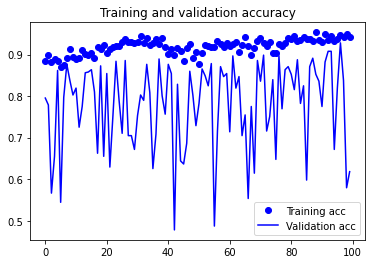

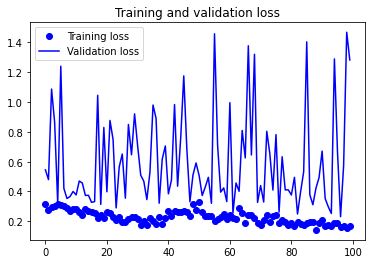

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()